In [1]:
%pip install pulp          # 최적화 모델링
%pip install numpy         # 수치 계산
%pip install scipy         # 과학 계산
%pip install matplotlib    # 시각화
%pip install geopandas     # 공간 데이터 처리

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# mac에서
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')  # 애플고딕 사용
plt.rcParams['axes.unicode_minus'] = False

# windows에서
# import matplotlib.pyplot as plt
# plt.rc('font', family='Malgun Gothic')  # 맑은 고딕 사용
# plt.rcParams['axes.unicode_minus'] = False


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10005 (\N{MULTIPLICATION X}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


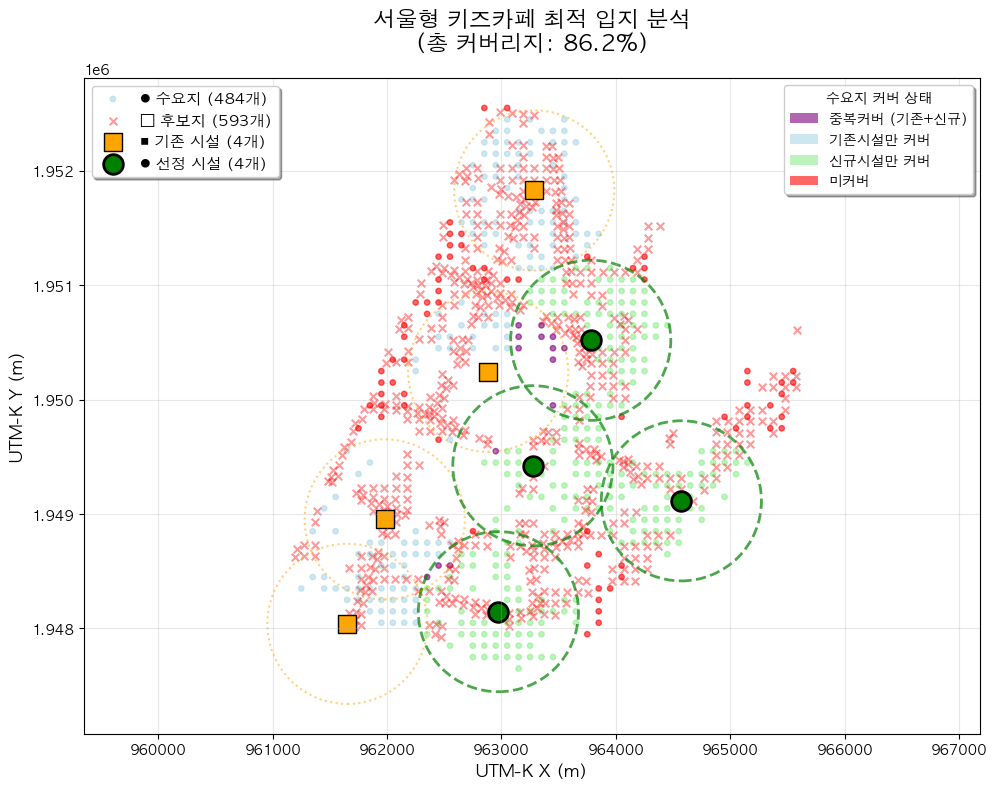

◆◆◆ 데이터 현황 ◆◆◆
수요지: 484개
후보지: 593개
기존 시설: 4개
선정 시설: 4개
◆◆◆ 커버리지 분석 결과 ◆◆◆
기존 시설 커버: 161개 (33.3%)
신규 추가 커버: 256개 (52.9%)
중복 커버: 14개 (2.9%)
총 커버리지: 417개 (86.2%)
미커버: 67개 (13.8%)
◆◆◆ 선정된 신규 시설 좌표 ◆◆◆
[1] X: 962973.37, Y: 1948146.79
[2] X: 963274.50, Y: 1949422.58
[3] X: 963780.15, Y: 1950519.49
[4] X: 964572.39, Y: 1949115.79


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import pulp
import matplotlib.pyplot as plt
from pyproj import Transformer

# 좌표계 변환기 생성 (WGS84 → UTM-K)
transformer = Transformer.from_crs("epsg:4326", "epsg:5179", always_xy=True)

# 1. 데이터 불러오기 및 좌표 변환
def load_and_convert(file_path):
    df = pd.read_csv(file_path)
    x, y = transformer.transform(df['_X'].values, df['_Y'].values)
    return np.column_stack([x, y])

demand_coords = load_and_convert('suyo2.csv')
candidate_coords = load_and_convert('hubo2.csv')
existing_coords = load_and_convert('kidscafes.csv')

# 2. 개선된 MCLP 함수 (기존 + 신규 총 커버리지 계산)
def mclp_total_coverage(demand_coords, candidate_coords, num_facilities, service_radius_m,
                       existing_coords=None, min_distance_m=0):
    
    # 1단계: 기존 시설 커버리지 계산
    existing_covered = np.zeros(len(demand_coords), dtype=bool)
    if existing_coords is not None and len(existing_coords) > 0:
        dist_existing = distance_matrix(demand_coords, existing_coords)
        existing_covered = (dist_existing <= service_radius_m).any(axis=1)
    
    # 2단계: 후보지 필터링 (기존 시설과의 거리 제약)
    valid_candidates = candidate_coords.copy()
    if existing_coords is not None and min_distance_m > 0:
        dist_to_existing = distance_matrix(candidate_coords, existing_coords)
        valid_mask = np.all(dist_to_existing >= min_distance_m, axis=1)
        valid_candidates = candidate_coords[valid_mask]
        print(f"필터링 후 유효 후보지: {len(valid_candidates)}개")
    
    # 3단계: 신규 시설 최적화 (기존 미커버 지역 우선)
    dist_matrix = distance_matrix(demand_coords, valid_candidates)
    coverage = (dist_matrix <= service_radius_m).astype(int)
    
    # 최적화 모델
    prob = pulp.LpProblem("MCLP_Total_Coverage", pulp.LpMaximize)
    x = pulp.LpVariable.dicts("x", range(len(valid_candidates)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand_coords)), cat='Binary')
    
    # 목적함수: 기존 시설로 커버되지 않은 수요지 우선 커버
    prob += pulp.lpSum(y[i] * (1 - existing_covered[i]) for i in range(len(demand_coords)))
    
    # 제약조건
    prob += pulp.lpSum(x[j] for j in range(len(valid_candidates))) == num_facilities
    for i in range(len(demand_coords)):
        prob += y[i] <= pulp.lpSum(x[j] * coverage[i,j] for j in range(len(valid_candidates)))
    
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # 4단계: 결과 분석
    selected = [j for j in range(len(valid_candidates)) if x[j].varValue == 1]
    selected_sites = valid_candidates[selected]
    
    # 신규 시설 커버리지 계산
    new_covered = np.zeros(len(demand_coords), dtype=bool)
    if len(selected_sites) > 0:
        dist_new = distance_matrix(demand_coords, selected_sites)
        new_covered = (dist_new <= service_radius_m).any(axis=1)
    
    # 총 커버리지 = 기존 커버 OR 신규 커버
    total_covered = existing_covered | new_covered
    
    # 커버리지 통계
    existing_count = np.sum(existing_covered)
    new_only_count = np.sum(new_covered & ~existing_covered)  # 신규로만 커버되는 수요지
    total_count = np.sum(total_covered)
    overlap_count = np.sum(existing_covered & new_covered)  # 중복 커버
    
    # 5단계: 시각화 (개수 표시 개선)
    plt.figure(figsize=(10, 8))
    
    # 수요지 색상 구분
    colors = []
    for i in range(len(demand_coords)):
        if existing_covered[i] and new_covered[i]:
            colors.append('purple')  # 기존+신규 중복 커버
        elif existing_covered[i]:
            colors.append('lightblue')  # 기존만 커버
        elif new_covered[i]:
            colors.append('lightgreen')  # 신규만 커버
        else:
            colors.append('red')  # 미커버
    
    # 각 요소별 플롯 (개수 명시)
    plt.scatter(demand_coords[:,0], demand_coords[:,1], c=colors, alpha=0.6, s=15,
                label=f'● 수요지 ({len(demand_coords)}개)')
    
    plt.scatter(candidate_coords[:,0], candidate_coords[:,1], c='red', marker='x', 
                alpha=0.4, s=30, label=f'✕ 후보지 ({len(candidate_coords)}개)')
    
    # 기존 시설 + 서비스 영역
    if existing_coords is not None:
        plt.scatter(existing_coords[:,0], existing_coords[:,1], 
                    c='orange', s=150, marker='s', edgecolor='black', linewidth=1,
                    label=f'■ 기존 시설 ({len(existing_coords)}개)')
        for site in existing_coords:
            circle = plt.Circle(site, service_radius_m, color='orange', 
                               fill=False, linestyle=':', linewidth=1.5, alpha=0.5)
            plt.gca().add_patch(circle)
    
    # 선정된 신규 시설 + 서비스 영역
    plt.scatter(selected_sites[:,0], selected_sites[:,1], 
                c='green', s=200, marker='o', edgecolor='black', linewidth=2,
                label=f'● 선정 시설 ({len(selected)}개)')
    for site in selected_sites:
        circle = plt.Circle(site, service_radius_m, color='green', 
                           fill=False, linestyle='--', linewidth=2, alpha=0.7)
        plt.gca().add_patch(circle)
    
    # 메인 범례 (시설 타입별)
    main_legend = plt.legend(loc='upper left', bbox_to_anchor=(0, 1), 
                            fontsize=11, frameon=True, fancybox=True, shadow=True)
    
    # 수요지 색상 설명을 위한 추가 범례
    from matplotlib.patches import Patch
    color_legend_elements = [
        Patch(facecolor='purple', alpha=0.6, label='중복커버 (기존+신규)'),
        Patch(facecolor='lightblue', alpha=0.6, label='기존시설만 커버'),  
        Patch(facecolor='lightgreen', alpha=0.6, label='신규시설만 커버'),
        Patch(facecolor='red', alpha=0.6, label='미커버')
    ]
    color_legend = plt.legend(handles=color_legend_elements, loc='upper right', 
                             bbox_to_anchor=(1, 1), title='수요지 커버 상태',
                             fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # 두 범례 모두 표시
    plt.gca().add_artist(main_legend)
    
    # 제목과 축 설정
    total_coverage_pct = total_count / len(demand_coords) * 100
    plt.title(f'서울형 키즈카페 최적 입지 분석\n(총 커버리지: {total_coverage_pct:.1f}%)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('UTM-K X (m)', fontsize=12)
    plt.ylabel('UTM-K Y (m)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 6단계: 상세 결과 출력
    print("=" * 60)
    print("◆◆◆ 데이터 현황 ◆◆◆")
    print(f"수요지: {len(demand_coords)}개")
    print(f"후보지: {len(candidate_coords)}개") 
    print(f"기존 시설: {len(existing_coords) if existing_coords is not None else 0}개")
    print(f"선정 시설: {len(selected)}개")
    print("=" * 60)
    
    print("◆◆◆ 커버리지 분석 결과 ◆◆◆")
    print(f"기존 시설 커버: {existing_count}개 ({existing_count/len(demand_coords)*100:.1f}%)")
    print(f"신규 추가 커버: {new_only_count}개 ({new_only_count/len(demand_coords)*100:.1f}%)")
    print(f"중복 커버: {overlap_count}개 ({overlap_count/len(demand_coords)*100:.1f}%)")
    print(f"총 커버리지: {total_count}개 ({total_coverage_pct:.1f}%)")
    print(f"미커버: {len(demand_coords) - total_count}개 ({(len(demand_coords) - total_count)/len(demand_coords)*100:.1f}%)")
    print("=" * 60)
    
    print("◆◆◆ 선정된 신규 시설 좌표 ◆◆◆")
    for idx, (x, y) in enumerate(selected_sites, 1):
        print(f"[{idx}] X: {x:.2f}, Y: {y:.2f}")
    
    return {
        'selected_sites': selected_sites,
        'total_coverage': total_coverage_pct,
        'existing_coverage': existing_count/len(demand_coords)*100,
        'new_coverage': new_only_count/len(demand_coords)*100,
        'overlap_coverage': overlap_count/len(demand_coords)*100
    }

# 3. 실행
result = mclp_total_coverage(
    demand_coords=demand_coords,
    candidate_coords=candidate_coords,
    num_facilities=4,
    service_radius_m=700,
    existing_coords=existing_coords,
    min_distance_m=0
)
